In [ ]:
cd ..

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from utils.genre_classification import feature_preparator
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool

In [2]:
BATCH_SIZE = 1

In [3]:
%%time
train_data_loader, test_data_loader1, test_data_loader2, idx_to_label = feature_preparator('features/genre_classification/mfcc24-zcr-sc-sr-sf-chr-flattened.p', BATCH_SIZE)

CPU times: user 50.6 ms, sys: 21.1 ms, total: 71.7 ms
Wall time: 71.8 ms


In [4]:
features = []

features_1 = ['mean', 'std', 'skew', 'kurtosis']
features_2 = {'mfcc': 24, 'zero_crossing_rate': 1, 'spectral centroid': 1, 'spectral rolloff': 1, 'spectral flattness': 1, 'chroma': 12}

for j in features_1:
    for feature, num in features_2.items():
        for i in range(num):
            features.append(f'{feature}_{i}_{j}')

In [5]:
def make_dataframe_from_dataloader(dataloader: DataLoader, column_names):
    all_features = []
    all_targets = []

    for features, target in dataloader:
        features = features.flatten()
        all_features.append(features.numpy())
        all_targets.append(target.numpy()[0])

    return pd.DataFrame.from_records(all_features, columns=column_names), pd.Series(all_targets)

def transform_idx_to_label(x):
    return idx_to_label[x]

In [6]:
train_df_x, train_df_y = make_dataframe_from_dataloader(train_data_loader, features)
test1_df_x, test1_df_y = make_dataframe_from_dataloader(test_data_loader1, features)
test2_df_x, test2_df_y = make_dataframe_from_dataloader(test_data_loader2, features)
test_df_x = pd.concat([test1_df_x, test2_df_x])
test_df_y = pd.concat([test1_df_y, test2_df_y])

Снижаем размерность

In [7]:
pca = PCA(n_components=100)

In [8]:
pca.fit(train_df_x)

PCA(n_components=100)

Сколько мы потеряли variance снизив размерность

In [9]:
1 - sum(pca.explained_variance_ratio_)

0.04842658410780132

In [10]:
train_df_x_pca = pca.transform(train_df_x)
test_df_x_pca = pca.transform(test_df_x)

In [11]:
adabooost_clf = AdaBoostClassifier(n_estimators=100, random_state=111)

In [12]:
adabooost_clf.fit(train_df_x_pca, train_df_y)

AdaBoostClassifier(n_estimators=100, random_state=111)

In [13]:
adaboost_predicted = adabooost_clf.predict(test_df_x_pca)

              precision    recall  f1-score   support

       Blues       0.36      0.34      0.35       501
   Classical       0.49      0.63      0.55       507
  Electronic       0.31      0.28      0.30       504
        Folk       0.34      0.31      0.32       498
     Hip-Hop       0.42      0.64      0.50       503
        Jazz       0.33      0.27      0.30       505
         Pop       0.19      0.07      0.10       473
        Rock       0.36      0.44      0.39       496

    accuracy                           0.37      3987
   macro avg       0.35      0.37      0.35      3987
weighted avg       0.35      0.37      0.35      3987



<AxesSubplot: >

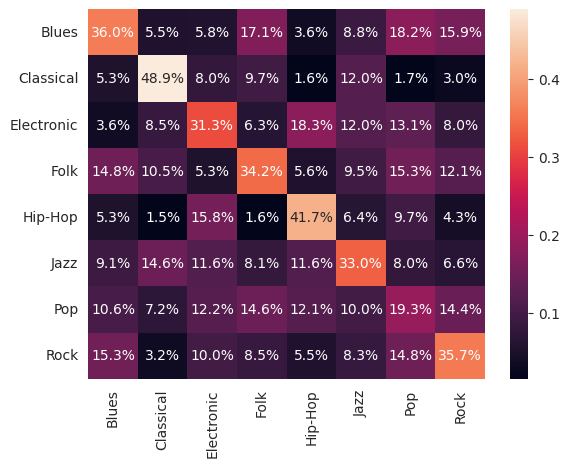

In [14]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, adaboost_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, adaboost_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%',)

In [15]:
xgb_dtrain = xgb.DMatrix(train_df_x_pca, label = train_df_y)
xgb_dtest = xgb.DMatrix(test_df_x_pca, label = test_df_y)
xgb_param = {
    'max_depth': 8,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'num_class': 8}
xgb_num_round = 100

In [16]:
xgb_clf = xgb.train(xgb_param, xgb_dtrain, xgb_num_round)
xgb_predicted_matrix = xgb_clf.predict(xgb_dtest)
xgb_predicted = np.asarray([np.argmax(line) for line in xgb_predicted_matrix])

              precision    recall  f1-score   support

       Blues       0.54      0.47      0.50       501
   Classical       0.57      0.68      0.62       507
  Electronic       0.39      0.37      0.38       504
        Folk       0.37      0.38      0.37       498
     Hip-Hop       0.53      0.63      0.58       503
        Jazz       0.42      0.39      0.40       505
         Pop       0.22      0.17      0.20       473
        Rock       0.42      0.45      0.43       496

    accuracy                           0.44      3987
   macro avg       0.43      0.44      0.44      3987
weighted avg       0.43      0.44      0.44      3987



<AxesSubplot: >

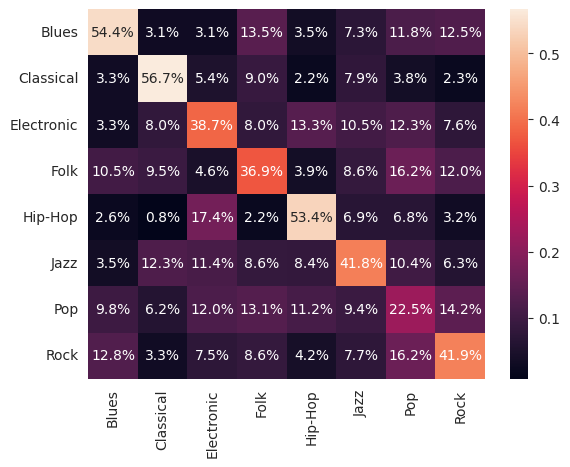

In [17]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, xgb_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, xgb_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%')

In [18]:
svm_clf = SVC(gamma='auto')
svm_clf.fit(train_df_x_pca, train_df_y)
svm_predicted = svm_clf.predict(test_df_x_pca)

              precision    recall  f1-score   support

       Blues       0.60      0.45      0.51       501
   Classical       0.58      0.70      0.64       507
  Electronic       0.38      0.50      0.43       504
        Folk       0.43      0.48      0.45       498
     Hip-Hop       0.58      0.62      0.60       503
        Jazz       0.47      0.43      0.45       505
         Pop       0.30      0.16      0.21       473
        Rock       0.45      0.48      0.47       496

    accuracy                           0.48      3987
   macro avg       0.47      0.48      0.47      3987
weighted avg       0.48      0.48      0.47      3987



<AxesSubplot: >

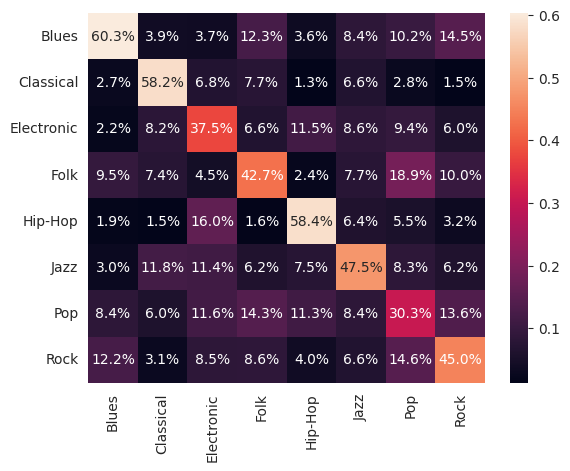

In [19]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, svm_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, svm_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%')

In [22]:
cat_clf = CatBoostClassifier(logging_level='Silent')
cat_clf.fit(train_df_x_pca, train_df_y)
cat_predicted = cat_clf.predict(test_df_x_pca)
cat_predicted = np.ravel(cat_predicted).tolist()

              precision    recall  f1-score   support

       Blues       0.53      0.45      0.49       501
   Classical       0.56      0.65      0.60       507
  Electronic       0.37      0.40      0.39       504
        Folk       0.37      0.41      0.39       498
     Hip-Hop       0.54      0.63      0.58       503
        Jazz       0.41      0.39      0.40       505
         Pop       0.28      0.18      0.22       473
        Rock       0.42      0.46      0.44       496

    accuracy                           0.45      3987
   macro avg       0.44      0.44      0.44      3987
weighted avg       0.44      0.45      0.44      3987



<AxesSubplot: >

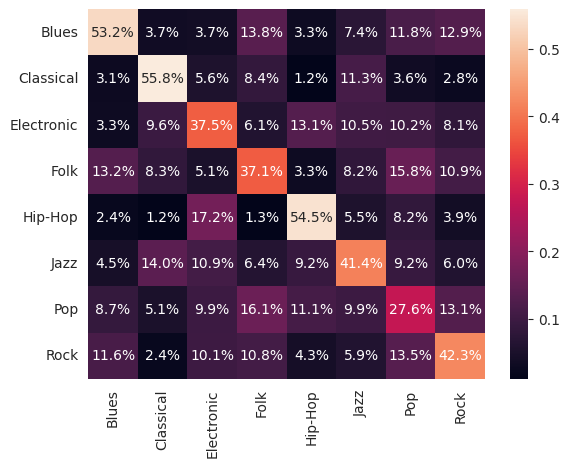

In [23]:
print(classification_report(list(map(transform_idx_to_label, test_df_y)), list(map(transform_idx_to_label, cat_predicted))))
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_df_y, cat_predicted)).rename(columns=idx_to_label, index=idx_to_label)
sns.heatmap(confusion_matrix_df / np.sum(confusion_matrix_df), annot=True, fmt='.1%')